<a href="https://colab.research.google.com/github/minerva-mcgonagraph/titanic/blob/master/TitanicML_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic: Machine Learning Model Part 1

On April 10, 1912 the unsinkable Titanic set sail on her maiden voyage. But we all know the story from here. Too-fast speeds, drifting icebergs, and possibly some fire damage led the Titanic to the bottom of the ocean five days later. A lack of lifeboats, which were only ever meant to ferry passengers to a rescue ship, unseasonably frigid waters, and the inaction of a nearby ship led to the deaths of two-thirds of those aboard. What was left was a passenger manifest, each row with a cruel label: 1 for Survived and 0 for Did Not Survive. 

![Screenshot from Titanic (1997) showing the ship setting sail from its dock.](https://m.media-amazon.com/images/M/MV5BMWFlOTk3MWYtOGIxOS00NTQ1LWFhODAtOWU5MDM3NzcwYTMwXkEyXkFqcGdeQXVyMjMzMDI4MjQ@._V1_SX1777_CR0,0,1777,999_AL_.jpg)

Screenshot from [IMDb](https://www.imdb.com/title/tt0120338/mediaindex?page=1&ref_=ttmi_mi_sm).

[Kaggle has created a competition](https://www.kaggle.com/c/titanic): develop a machine learning model to predict which passengers survived. In this notebook, we will develop such a model, using features as class, gender, age, and more. The focus of this notebook is on cleaning data and data engineering, so the models themselves will be simple.

First we'll look at a few basic features to get a working model. Then we'll look deeper at the string data such as names and ticket numbers and see if that improves the model. Finally we'll do more improvements and test our model against brand new, fictional data: characters from the 1997 movie.



To read this notebook, simply scroll through - don't run the cells. If you wish to run the cells, you will need to create an account on Kaggle and download the API token for your account. It's free, just follow the instructions in the setup below.

# Setup

In [0]:
#import libraries
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from google.colab import files

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:.2f}'.format

In [0]:
#get info to get data from kaggle
#if you, friend, wish to run this, you will need to:
#1. Create a kaggle account
#2. Sign up for the ongoing Titantic competition
#3. In account settings, generate a new API token (a json file) and download it
#4. Make sure it's named kaggle.json
#5. Run this cell to upload it here
#it's all free :)
files.upload()

In [0]:
#get data from kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

!pip install -q kaggle
!pip install -q kaggle-cli

!kaggle competitions download -c titanic

print("The data is ready, m'lord.")

In [0]:
#turn each csv into a pandas dataframe
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_both = [df_train, df_test]

#randomize the training data
df_train = df_train.reindex(np.random.permutation(df_train.index))

# First Look at the Data

First let's look at what we're dealing with. We'll look at the data types and feature descriptions.

In [0]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

From [Kaggle](https://www.kaggle.com/c/titanic/data):

Survived: 0 = No, 1 = Yes

Pclass: ticket class: 1, 2, or 3

Sex: male or female

Age: age in years; age is fractional if less than 1. If the age is estimated, it is in the form of xx.5

SibSp: number of siblings, spouses also aboard; siblings include brother, sister, and stepbrother and stepsister; spouse includes husband or wife - fiances and mistresses were ignored

Parch: number of parents, children also aboard; parent includes mother or father; child includes son, daughter, stepdaughter, stepson. Does not include nannies - some children travelled only with a nanny so this value is 0 for them.

ticket: ticket number

fare: passenger fare

cabin: cabin number

embarked: port of embarkation; C = Cherbourg, Q = Queenstown, S = Southampton

For this model, our target (label) is Survived, which is a binary 1 (survived) or 0 (did not survive).

Our available columns to use for features are Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, and Embarked. Let's see what these look like. (PassengerId is just the number of the row in the original list - it's not a feature to use). We'll leave Name, Ticket, and Cabin alone for now, since they are string values that would require some fancier engineering.

In [0]:
df_train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
322,323,1,2,"Slayter, Miss. Hilda Mary",female,30.00,0,0,234818,12.35,NaN,Q
274,275,1,3,"Healy, Miss. Hanora ""Nora""",female,nan,0,0,370375,7.75,NaN,Q
650,651,0,3,"Mitkoff, Mr. Mito",male,nan,0,0,349221,7.90,NaN,S
613,614,0,3,"Horgan, Mr. John",male,nan,0,0,370377,7.75,NaN,Q
793,794,0,1,"Hoyt, Mr. William Fisher",male,nan,0,0,PC 17600,30.70,NaN,C
37,38,0,3,"Cann, Mr. Ernest Charles",male,21.00,0,0,A./5. 2152,8.05,NaN,S
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.00,0,4,349909,21.07,NaN,S
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.00,1,1,36928,164.87,NaN,S
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.00,0,0,230434,13.00,NaN,S
345,346,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.00,0,0,248733,13.00,F33,S


From here, we'll start with the purely numeric features Pclass, Age, SibSp, Parch, and Fare, and we'll one-hot encode the categorical features Sex and Embarked. We'll leave Name, Ticket, and Cabin for later, since those are more complicated.

First we'll look at some summary statistics for the numeric features.

In [0]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


Now let's look at a correlation matrix to see what features we should consider using. Values close to 0 imply the feature is not very useful. Values close to 1 imply a strong positive correlation and values close to -1 imply a strong negative correlation - these features will help train our model.

The two features most strongly correlated with survival are Pclass and Fare. But notice that these features are also correlated with each other: this means that using both may not add much to the model. 

But since the number of our features and examples is on the scale of hundreds rather than millions, we can add features freely without worrying about training time. So for now we will consider all features.

In [0]:
df_train.corr(method='pearson')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


# Cleaning the Data

Now let's start wrangling the data. The goal is to fill in missing values and make the data as simple as possible.

For Age and Fare, we can sort the data into bins to make the numbers smaller and account for outliers. But first notice that the count for Age is 714 instead of the 891 for the other columns. This means that some values for Age are missing, and we will need to fill them in to train our model. We'll fill them in using the mean.

Next we'll one-hot encode Sex and Embarked. We'll create a new column Female and Columns for each of the three embarkation locations, marking a 1 if a passenger is female and a 1 in the column they embarked from.

We don't need a column for male or any other gender since the manifest lists exactly two genders, so a passenger is either one gender (female) or not.

To bin Age, we'll first compare Age to Survival.

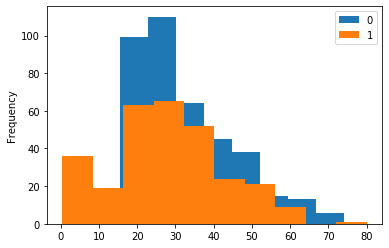

In [0]:
df_train.groupby('Survived')['Age'].plot(kind='hist')
plt.legend()

From this we can see that children under 16 were much more likely to survive than not survive, and young adults from 16 to about 30 were more likely not to survive. Similarly, adults aged about 40 to 50 were less likely to survive. From this, bins with a length of 16 would group the data fairly well to correlate with survival.

Now we'll do the same with Fare. But when we try the same code, we get a plot that's a little hard to understand.

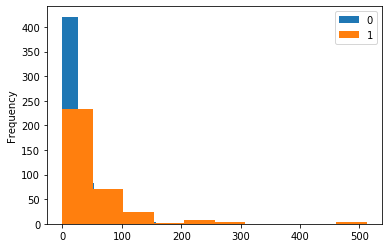

In [0]:
df_train.groupby('Survived')['Fare'].plot(kind='hist')
plt.legend()

This is because Fare contains some heavy outliers. We'll instead manually bin the data based on its quartiles. We'll also use a logarithmic scale for the $x$-axis for readability.

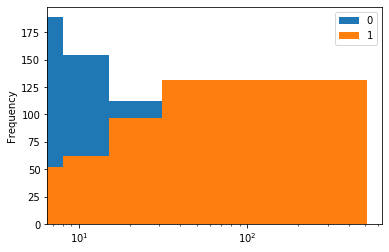

In [0]:
df_train.groupby('Survived')['Fare'].plot(kind='hist', bins=[0, 8, 15, 31, 513])
plt.xscale('log')
plt.legend()

From here we can see that passengers whose fares were in the lower half were much less likely to survive. We'll bin the data based on these values.

In [0]:
def clean_features(df):
  """Converts string categorical features into numeric ones. Also fills null values.

  Args:
    df: A pandas DataFrame expected to contain the Titanic data.
  Returns:
    A DataFrame that contains some features to be considered in the model;
    does not include synthetic features.
  """
  selected_features = df[['Sex','Embarked', 'Age', 'Fare']]
  cleaned_features = pd.DataFrame()

  #Sex: convert to binary value
  cleaned_features['Female'] = np.multiply(df.Sex == 'female', 1)

  #Embarked: one-hot encode
  cleaned_features['Q'] = np.multiply(df.Embarked == 'Q', 1)
  cleaned_features['S'] = np.multiply(df.Embarked == 'S', 1)
  cleaned_features['C'] = np.multiply(df.Embarked == 'C', 1)

  #Age: fill NaNs with mean
  age_mean = selected_features.Age.dropna().mean()
  cleaned_features['Age'] = selected_features['Age'].fillna(value=age_mean)
  cleaned_features['Age'] = cleaned_features['Age'].astype(int)

  #Age: bin data into 5 groups (of length 16)
  cleaned_features['Age'] = pd.cut(cleaned_features['Age'], 5, labels=[1, 2, 3, 4, 5])
  cleaned_features['Age'] = cleaned_features['Age'].astype(int)

  #Fare: bin data based on quartiles
  cleaned_features['Fare'] = pd.cut(selected_features['Fare'],[-1, 8, 15, 31, 513], labels=[1, 2, 3, 4])
  cleaned_features['Fare'] = cleaned_features['Fare'].astype(int)

  #print(cleaned_features.dtypes)

  return cleaned_features

In [0]:
clean_features(df_train)

,Female,Q,S,C,Age,Fare
66,1,0,1,0,2,2
750,1,0,1,0,1,3
782,0,0,1,0,2,3
695,0,0,1,0,4,2
200,0,0,1,0,2,2
...,...,...,...,...,...,...
536,0,0,1,0,3,3
123,1,0,1,0,2,2
567,1,0,1,0,2,3
407,0,0,1,0,1,3


# Engineering the Data

Now we can look into some feature engineering. Let's first create a Women & Children feature, since we know that women and children were boarded onto lifeboats first and so were more likely to survive. We'll create a binary column with 1 if a passenger was female or at most 16 and 0 otherwise.

In [0]:
def preprocess_features(df):
  """Prepares input features from the DataFrame.

  Args:
    df: A pandas DataFrame expected to contain the Titanic data, already cleaned.
  Returns:
    A DataFrame that contains the features to be used in the model, including
      synthetic features.
  """
  selected_features = df[['Pclass']]

  #Add cleaned features
  selected_features = pd.concat([selected_features, clean_features(df)], axis=1, sort=False)

  processed_features = selected_features.copy()

  #Create synthetic features

  #Create feature that logs if a passenger is female or a child.
  #Note that Age has been binned, so Age = 1 corresponds to ages up to 16.
  processed_features['F or Child'] = 0
  processed_features['F or Child'].loc[clean_features(df).Age == 1] = 1
  processed_features['F or Child'].loc[clean_features(df).Female == 1] = 1  

  return processed_features

In [0]:
preprocess_features(df_train)

,Pclass,Female,Q,S,C,Age,Fare,F or Child
66,2,1,0,1,0,2,2,1
750,2,1,0,1,0,1,3,1
782,1,0,0,1,0,2,3,0
695,2,0,0,1,0,4,2,0
200,3,0,0,1,0,2,2,0
...,...,...,...,...,...,...,...,...
536,1,0,0,1,0,3,3,0
123,2,1,0,1,0,2,2,1
567,3,1,0,1,0,2,3,1
407,2,0,0,1,0,1,3,1


# Buiding the Model

Now let's build our model. We'll separate the data into features and labels and then use logistic regression to predict survival. 

In [0]:
features = preprocess_features(df_train)
targets = df_train['Survived']
test_features = preprocess_features(df_test)

In [0]:
logreg = LogisticRegression()
logreg.fit(features, targets)
predictions = logreg.predict(test_features)
acc_log = round(logreg.score(features, targets)*100, 2)
print(acc_log)


79.91


And with that, we have an accuracy of 79.91%. Not bad, but probably could be better. Or perhaps use fewer features to obtain the same accuracy. 

In Part 2 (coming soon) we'll look at wrangling the string data.